# Introduction

In this tutorial, we will expand upon [Serial Recall Model 1](../Serial_Recall_1/Serial_Recall_Model_1.ipynb) in order to develop a model that also accounts for the primacy effect. The extended model incorporates a rehersal strategy which produces the a primacy effect by rehersing items at the begining of the list more than other items.

# Serial Recall Task

The serial recall task consists of two phases: the learning phase and the test phase. During the learning phase, each word is presented individually for 2 seconds. This words a presented again in the same order. During the test phase, the participant is asked to recall each word in the same order in which the list items were learned. 


# Serial Recall Model 2

## Basic Strategy

Below, we introduce the basic strategy of the Serial Recall Model 2 for the learning and test phases.

### Learning Phase

During the learning phase, the model encodes each presented word and its position within the list. After encoding the word, the model will attempt to rehearse the previous items until a new word is presented. A few simplifying assumptions will be made to make the model tractible. First, we will assume that both encoding and rehearsal requires approximately .5 seconds. Thus, within a 2 second period, the model can encode the presented word and rehearse three previously learned words. Second, we assume that the model begins rehearsal with the first word and continues until a new word is presented on the screen. If the end of the list is reached during rehearsal, such as when only one word has been presented, the model continues to rehearse from the beginning of the list. 


### Test Phase 

During the test phase, the model performs successive memory retrievals using position $i \in \{1,2,\dots,N\}$ as a cue or retrieval request for recalling the list in the correct order. As a departure from [Serial Recall Model 1](../Serial_Recall_1/Serial_Recall_Model_1.ipynb), the present model guesses randomly among non-retrieved chunks in the event of a retrieval failure. As a result, the model is a mixture of retrieval and guessing processes. 



## Declarative memory

Declarative memory $M$ consists of a set of chunks, one for each word studied in the learning phase. Let $Q = \{\textrm{word, position, retrieved}\}$ be set of slots for each chunk. The slot "word" is associated with the studied word, the slot "position" is associated with the chunk's order within the list and the value associated with the slot retrieved indicates whether the chunk has been retreived during the test phase (1: retrieved; 0: not retrieved) , a slot for its position within the study list, and a slot that indicates whether the chunk has been retrieved during the test phase. 


## Inhibition of Return

Inhibition of return functions the same as with  [Serial Recall Model 1](../Serial_Recall_1/Serial_Recall_Model_1.ipynb). Once any chunk $m$ is marked as $c_m(\rm retrieved) = 1$, it cannot be retrieved again. The set of chunks eligible for retrieval is defined as:

\begin{align}
    R_i = \{\mathbf{c}_m \in M: c_m(\rm retrieved) = 0\}
\end{align}


## Retrieval Request

For each position $i \in \{1,2,\dots, N\} $, the model submits a retrieval request to declarative memory, defined formally as:  

\begin{align}
    \mathbf{r}_i = \rm \{(position,i),(retrieved,0)\}
\end{align}

where the corresponding slot set for the retrieval request is $Q_r = \rm \{position,retrieved\}$. 

## Response Mapping

The value in the word slot of the rectrieved chunk $r$ defines the response:

\begin{align*}
y_i = c_r(\rm word)
\end{align*}


## Activation

Activation for $\mathbf{c}_m is given by the following equation:

\begin{align}
    a_{m} = \rm bll_m + \rho_m + \epsilon_m
\end{align}


where the term $\rm bll_m$ represents base level learning, the term $\rho_m$ represents activation from partial matching, and $\epsilon ~ \rm Normal(0, \sigma)$. Base level learning controls the dynamics of learning and decay with the following hybrid approximation:

\begin{align}
    \textrm{bll}_m \approx  \textrm{LN}\left(\sum_{j=1}^{k} t_{mj}^{-d} + \frac{(N_m-k)(L_m^{1-d} - t_{mk}^{1-d}) }{(1-d)(L_m - t_{mk})}\right)
\end{align}

where $L_m$ is the lifetime of the chunk (the time since its creation), $N_m$ is the number of times that chunk $m$ has been used, $d \in \left[0,1\right]$ is a decay parameter, and $t_k$ is the time since the $k^{th}$ use of the chunk. The hybrid only tracks the exact time stamps for the most recent subset of $k$ uses of the chunk. Simply tracking the most recent use $k=1$, is sufficient for a very accurate approximation.

Partial matching is based on the absolute difference between the slote value of chunk $m$ and the retrieval request $\mathbf{r}_i$:

\begin{equation}\label{eq:penalty}
\rho_m  = \delta \sum_{q \in Q_r}| c_m(q) - r_i(q) | 
\end{equation}

where parameter $\delta$ represents sensitivity to the absolute difference. 


## Response Probability

The probability of responding with word $w$ is a mixture of retrieving $w$ and guessing $w$ given that a retrieval failure occured. Formally, this is expressed as:

$\rm \Pr(Y_i=y_i \mid \delta, \tau, d ; \mathbf{r}_i) = \rm \Pr(\mathbf{c}_r \mid \delta, \tau, d; \mathbf{r}_i) + \Pr(\mathbf{c}_{m^{\prime}}\mid \delta, \tau, d, ; \mathbf{r}_i)\theta_g$

The approximate probability of retrieving chunk $m$ among the eligible set of chunks that have not yet been retrieved is given by:


\begin{align}
     \Pr(\mathbf{c}_m \mid \delta, \tau, d; \mathbf{r}_i) = \frac{ e^{\frac{\mu_m}{\sigma}}}{\sum_{\mathbf{c}_k \in R_i} e^{\frac{\mu_k}{\sigma}} + e^{\frac{\mu_{m^\prime}}{\sigma}}}
\end{align}


where $\mu_a = \rm bll_m + \rho_m$ is the deterministic component of activation. Similarly, the probability of a retrieval failure is 

\begin{align}
     \Pr(\mathbf{c}_{m^{\prime}} \mid \delta, \tau, d; \mathbf{r}_i) = \frac{ e^{\frac{\mu_{m^{\prime}}}{\sigma}}}{\sum_{\mathbf{c}_k \in R_i} e^{\frac{\mu_k}{\sigma}} + e^{\frac{\mu_{m^\prime}}{\sigma}}}
\end{align}



The guessing probability is defined as

\begin{align}
     \theta_g = \frac{1}{|R_i|}
\end{align}

where $|R_i|$ denotes number of elements in the set of non-retrieved chunks. This means that the model guesses with equal probability among eligible chunks.  

## Processing Times

The time required to retrieve chunk $m$ is an inverse function of activation:

\begin{align}
\textrm{rt} \sim e^{a_m}
\end{align}

We make some simplifying assumptions about the processing time of conflict resolution (the time to select a production rule) and the response time. First, we assume that those times are deterministic, but memory retrieval is stochastic. Second, we assume conflict resolution is .05 seconds and the time to type a word is approximately 1 second. A more realistic model could compute motor execution time as a linear function of the number of letters in the word. However, assuming that short words can be typed in approximately 1 second does not alter the predictions much. 

## Likelihood Function

Define $\mathbf{Y} = \{y_1,y_2,\dots,y_{N}\}$ as a set of responses. The likelihood function is defined as

\begin{align}
\mathcal{L}(\Theta \mid \mathbf{Y}) = \prod_{i=1}^N \Pr(Y_i = y_i \mid \delta, \tau, d; \mathbf{r}_i)
\end{align}


## Assumptions

The following is a summary of the model's assumptions:


1. Responses are a mixture of retrieval and guessing processes
2. Each chunk can only be retrieved once during the test phase
3. Activation varies according to learning and forgetting dynamics
4. Activation is a decreasing function of the distance between the position value of the chunk and the position value of the retrieval request

To begin, we will load the required files and libraries. 

In [13]:
# set the working directory to the directory in which this file is contained
cd(@__DIR__)
# load the package manager
using Pkg
# activate the project environment
Pkg.activate("../../../")
# load the required packages
using Turing, StatsPlots, Revise, ACTRModels
# load all model functions
include("Serial_Recall_Model_2.jl")
# seed random number generator
Random.seed!(2920);

# Generate Data

In the code block below,  we will define three functions to generate simulated data from the model. The `simulate` function accepts the following arguments:

- parms: a `NamedTuple` of fixed parameters
- n_study: the times a list is studied in the study phase
- n_items: the number of simulated trials per block
-$\delta$: mismatch penalty parameter
-$\tau$: retrieval threshold parameter
-d: activation decay parameter

`simulate` initializes the model objects, sets the parameters and calls the `simulate_study!` and `simulate_test!` functions.

## Learning Phase

The function `simulate_study!` simulates the encoding and rehearsal processes which occur during the learning phase. Once a new study word is presented, the model encodes before begining a rehearsal process. During rehearsal, the model starts at the beginning of the list and rehearses the list in order until the next study item is presented. If the model reaches the end of the list, it begins an additional rehearsal sequence at the begining of the list. 

## Test Phase

In the function `simulate_test!`, the model iterates through a sequence of memory retrievals, using the index `i` as a cue in the retrieval request. The function `retrieval_probs` returns a vector of probabilities associated with retrieving each chunk. Next, a chunk index `resp` is randomly selected from the multinomial distribution. If a retrieval failure occurs, the model guesses a non-retrieved chunk with equal probability. Next, the retrieval time `rt` and response time (1.05 seconds) is added to `cur_time`. 

## Simulated Data

Simulated data are stored in an array of `NamedTuples`, where each `NamedTuple` corresponds to a trial. The `NamedTuple` stores the state of the memory system in `state`, the of the retrieval request in `cur_time`, the correct position in `position` and the position of the retrieved chunk in `resp`. In principle, it is possible to reconstruct the state of the memory system for each trial (e.g. $N_m$, $L_m$ etc) because we know the time stamps for stimulus onset and the time course of information processing within the model. Rather than reconstructing these states from observations, we make a deep copy of the memory system to make the process easier. Note that if we assumed conflict resolution and motor responses are stochastic rather than deterministic, it would be necessary to account for this uncertainty with a much more complex model. 

In [14]:
function simulate(parms, n_study, n_items; δ, τ, d)
    chunks = initialize_memory()
    # populate declarative memory with chunks
    memory = Declarative(;memory=chunks)
    # initialize the ACTR object
    actr = ACTR(;declarative=memory, parms..., δ, τ, d)
    # initialize time
    cur_time = 0.0
    # study list items
    cur_time = simulate_study!(actr, n_study, n_items, cur_time)
    # add 3 second delay between study and test phases
    cur_time += 1.0
    return simulate_test!(actr, n_items, cur_time)
end

function simulate_study!(actr, n_study, n_items, cur_time)
    # stimulus presentation rate
    p_rate = 2.0
    encoding_time = 0.5
    rehersal_time = 0.5
    chunks = actr.declarative.memory
    # repeat study list
    for rep ∈ 1:n_study
        # loop through each chunk
        for m ∈ 1:n_items
            # increment time
            cur_time += encoding_time
            add_chunk!(actr, cur_time; position=m, retrieved=[false])
            # rehersal index
            r = 1
            # reherse from r ∈ 1:m while time remaining
            while mod(cur_time, p_rate) != 0 
                # increment time
                cur_time += rehersal_time
                # update chunk
                update_chunk!(chunks[r], cur_time)
                #reset reloop through if necessary
                r  = r == m ? 1 : r += 1
            end
        end
    end
    return cur_time
end

function simulate_test!(actr, n_items, cur_time)
    parms = actr.parms
    data = Array{NamedTuple,1}(undef,n_items)
    chunks = actr.declarative.memory
    chunk = deepcopy(chunks[1])
    rt = 0.0
    for i ∈ 1:n_items
        cur_time += 0.05
        # compute retrieval probabilities θ for retrieval request current position i and non-retrieved chunks
        θ,request = retrieval_probs(actr, cur_time; position=i, retrieved=[false])
        n_choices = length(θ)
        # select a random chunk index weighted by retrieval probabilities
        chunk_id = sample(1:n_choices, Weights(θ))
        compute_activation!(actr, cur_time; position=i, retrieved=[false])
        if chunk_id == n_choices
            # guessing process
            chunk = rand(request)
            rt = compute_RT(actr, Chunk[])
        else
            # retrieval process
            chunk = request[chunk_id] 
            rt = compute_RT(actr, chunk)
        end
        # add state, position, respose and current time to data
        data[i] = (state = deepcopy(chunks), position=i, resp=chunk.slots.position,
             cur_time=cur_time)
        cur_time += rt
        # set retrieved chunk to retrieved = true
        modify!(chunk.slots, retrieved=true)
        # time to respond
        cur_time += (0.05 + 0.5)
    end
    return data
end

simulate_test! (generic function with 1 method)

Let's determine whether `simulate_study!` produces the desired rehersal distribution. The next code block simulates the study phase and plots the number of rehersals as a function of item position. As expected, the rehersal strategy produces a skewed distribution in which items at the beginning of the list are rehersed more than the remaining items. 

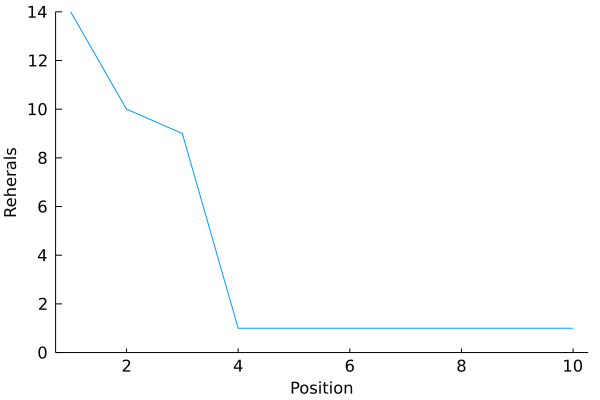

In [15]:
chunks = initialize_memory()
# populate declarative memory with chunks
memory = Declarative(;memory=chunks)
# initialize the ACTR object
actr = ACTR(;declarative=memory, parms..., δ, τ, d)
# initialize time
cur_time = 0.0
# study list items
simulate_study!(actr, n_study, n_items, cur_time)
ns = map(x ->x.N, chunks)
plot(ns, grid=false, leg=false, xaxis=font(11), yaxis=font(11), xlabel="Position", ylabel="Reherals", 
    ylims=(0,14), size=(600,400))

Now that our `simulate` function has been defined, we can now generate some data. The code block below generates 10 blocks of 10 trials and stores the simulated data in a nested array where each sub-array corresponds to a block of trials. 

In [16]:
# mismatch penalty parameter
δ = 1.0
# retrieval threshold parameter
τ = -1.0
# activation decay parameter
d = 0.5
# number of blocks
n_blocks = 10
# number of items per block
n_items = 10
# number of times each list is studied
n_study = 1
# fixed parameters
parms = (s = 0.3,mmp = true,noise = true,mmpFun = penalty, bll=true)
data = map(x -> simulate(parms, n_study, n_items; δ, τ, d), 1:n_blocks);

## Define Likelihood Function

In the code below, we define a custom distribution object for the Guessing Mixture model with the following fields:

- parms: a `NamedTuple` of fixed parameters
-$\delta$: mismatch penalty parameter
- n_items: he number of simulated trials per block

The function `computeLL` operates in a similar manner to the function `simulate`, which generates data from the model. The function `computeLL` begins by initializing the declarative memory and ACT-R objects. For each block of trials in the for loop, `reset_memory` resets the retrieved slot of each chunk to false and `block_LL` computes the log likelihood for a given block of trials. `block_LL` iterates over the data for each trial and computes the trial log likelihood. 

As a side note, you may have noticed that the value of the slot "retrieved" in `populate_memory` is a Boolean array. Slot-value pairs for each chunk are stored in a `NamedTuple`, which is an immutable data structure. However, elements of collections, such as arrays, within `NamedTuples` can be modified in terms of value but not type.  Wrapping the value in an array allows us to change the value without compromising performance by using a mutable data structure. 

In [17]:
using Parameters, Distributions, StatsFuns, StatsBase
import Distributions: logpdf, rand, loglikelihood

struct SerialRecall{T1,T2,T3,T4} <: ContinuousUnivariateDistribution
    δ::T1
    τ::T2
    d::T3
    parms::T4
    n_trials::Int
end

Broadcast.broadcastable(x::SerialRecall) = Ref(x)

SerialRecall(;δ, τ, d, parms, n_trials) = SerialRecall(δ, τ, d, parms)

loglikelihood(d::SerialRecall, data::Array{<:Array{<:NamedTuple,1},1}) = logpdf(d, data)

function logpdf(d::SerialRecall ,data::Array{<:Array{<:NamedTuple,1},1})
    return computeLL(d.parms, data, d.n_trials; δ=d.δ, τ=d.τ, d=d.d)
end

function computeLL(parms, all_data, n_items; δ, τ, d)
    act = zero(typeof(δ))
    chunks = populate_memory(n_items, act)
    # populate declarative memory with chunks
    memory = Declarative(;memory=chunks)
    # initialize the ACTR object
    actr = ACTR(;declarative=memory, parms..., δ, τ, d)
    # initialize time
    cur_time = 0.0
    # initialize log likelihood
    LL = 0.0
    # loop over each block of data
    for data in all_data
        # compute log likelhood of block data
        LL += block_LL(actr, data)
    end
    return LL
end

function block_LL(actr, data)
    # initialize block log likelihood for block
    LL = 0.0
    # iterate over each block trial
    for k in data 
        set_state!(actr, k.state)
        request = retrieval_request(actr; position=k.position, retrieved=[false])
        # get the retrieved trucked
        chunk = get_chunks(actr; position=k.resp, retrieved=[false])
        # compute the probability of the retrieved chunk and retrieval failure
        θᵣ,rf = retrieval_prob(actr, chunk, k.cur_time; position=k.position, retrieved=[false])
        θ = θᵣ + rf*(1/length(request))
        # increment the log likelihood LL
        LL += log(θ)
    end
    return LL
end

block_LL (generic function with 1 method)

## Define Model
The following summaries the prior distributions and the likelihood. 

\begin{align}
\delta \sim \rm Normal(1.0,.5)
\end{align}

\begin{align}
\theta_i = \Pr(Y_i = y_i \mid \delta, \tau, d; \mathbf{r}_i)
\end{align}

\begin{align}
y_{i} \sim \rm Bernouli(\theta_i)
\end{align}

In the code block below, the model is specified for Turing. 

In [18]:
@model model(data, parms, n_items) = begin
    δ ~ truncated(Normal(1.0, 0.5), 0, Inf)
    τ ~ Normal(-1.0, 0.5)
    d ~ Beta(5, 5)
    data ~ SerialRecall(δ, τ, d, parms, n_items)
end

model (generic function with 1 method)

## Estimate Parameters

Now that the priors, likelihood and Turing model have been specified, we can now estimate the parameters. In the following code, we will run four MCMC chains with the NUTS sample for 2,000 iterations and omit the first 1,000 warmup samples. 

In [19]:
# Settings of the NUTS sampler.
n_samples = 1000
n_adapt = 1000
n_chains = 4
specs = NUTS(n_adapt, 0.8)
# Start sampling.
chain = sample(model(data, parms, n_items), specs, MCMCThreads(), n_samples, n_chains, progress=true)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/dfish/.julia/packages/Turing/pwMQO/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/dfish/.julia/packages/Turing/pwMQO/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/dfish/.julia/packages/Turing/pwMQO/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/dfish/.julia/packages/Turing/pwMQO/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/dfish/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/dfish/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will

Chains MCMC chain (1000×15×4 Array{Float64, 3}):

Start time        = 2021-05-05T09:09:06.426
Stop time         = 2021-05-05T09:09:54.623
Wall duration     = 48.2 seconds
Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = d, δ, τ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           d    0.4915    0.1224     0.0019    0.0030   1982.7932    1.0008    ⋯
           δ    0.8448    0.2512     0.0040    0.0051   2496.6019    1.0008    ⋯
           τ   -1.0630    0.3662     0.0058    0.0091   1842.7158    1.0014    ⋯
                                                                1 

## Results

### Diagnostics

The first panel for each plot shows good mixing between the four chains. Additionally, in the summary above, $r\hat \approx 1$ for each parameter. In the second panel for each plot, the auto-correlation between successive samples drops rapidly after a lag of about 3-5, indicating efficient sampling.

### Posterior Distributions

The density plots located in the third panel of each plot below show that the posterior distributions are centered near the data-generating parameter values of $\delta = 1$, $\tau = -1$, and $d = .5$. 



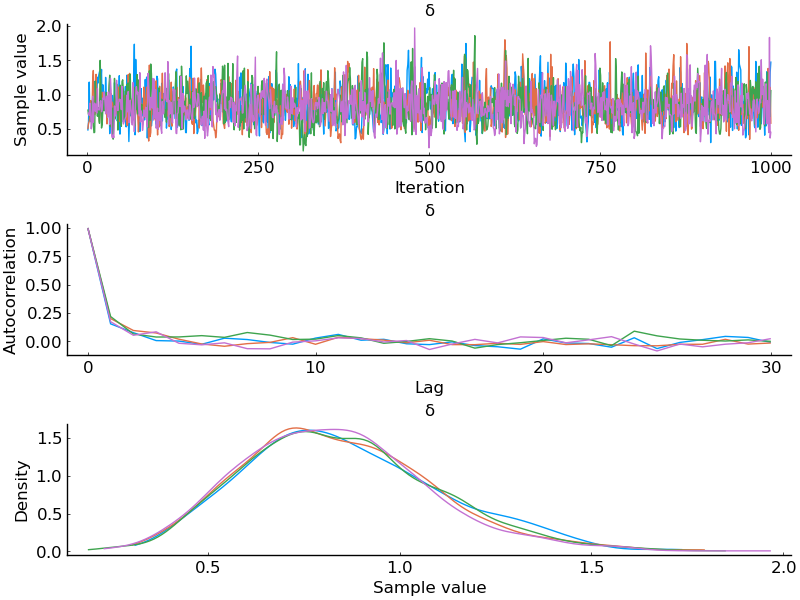

In [20]:
pyplot()
font_size = 12
ch = group(chain, :δ)
p1 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:traceplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p2 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:autocorplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p3 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:mixeddensity),
  grid=false, size=(250,100), titlefont=font(font_size))
pcτ = plot(p1, p2, p3, layout=(3,1), size=(800,600))

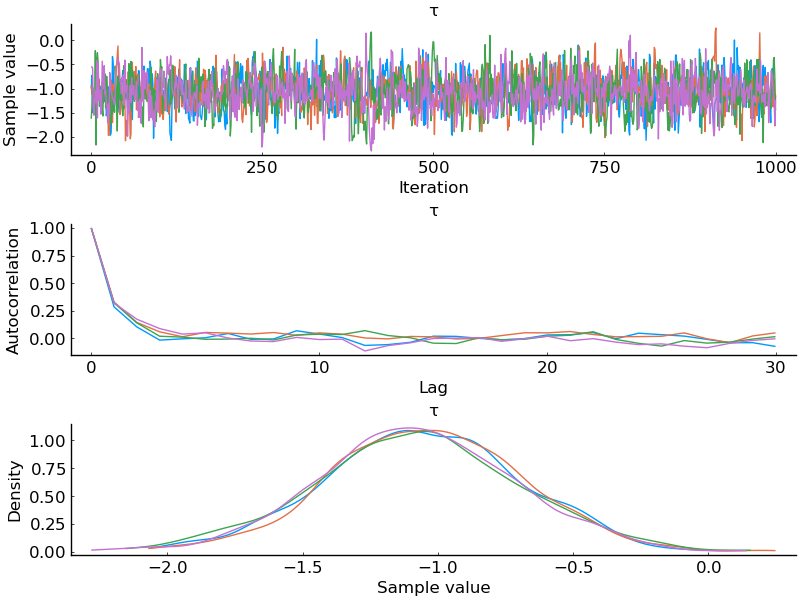

In [21]:
ch = group(chain, :τ)
p1 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:traceplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p2 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:autocorplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p3 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:mixeddensity),
  grid=false, size=(250,100), titlefont=font(font_size))
pcτ = plot(p1, p2, p3, layout=(3,1), size=(800,600))

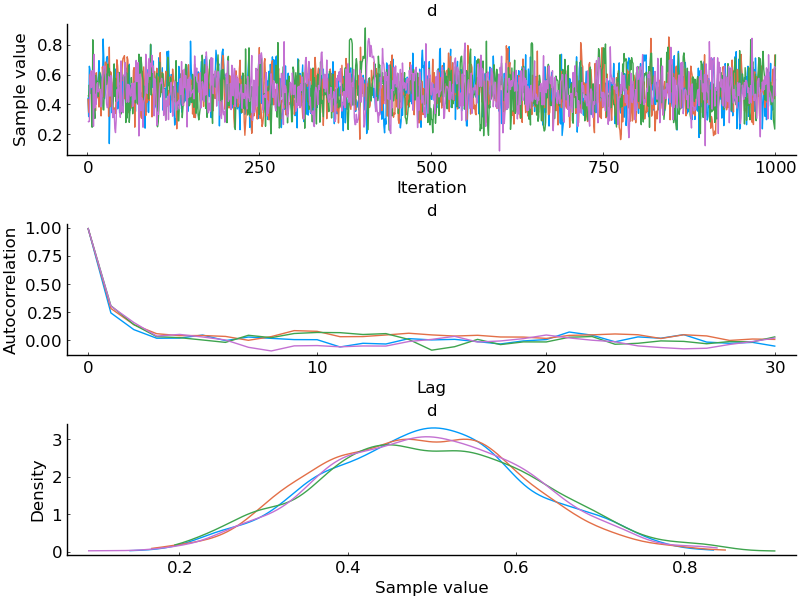

In [22]:
ch = group(chain, :d)
p1 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:traceplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p2 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:autocorplot),
  grid=false, size=(250,100), titlefont=font(font_size))
p3 = plot(ch, xaxis=font(font_size), yaxis=font(font_size), seriestype=(:mixeddensity),
  grid=false, size=(250,100), titlefont=font(font_size))
pcd = plot(p1, p2, p3, layout=(3,1), size=(800,600))

### Posterior Predictive Distributions

#### Transposition Errors

The code block below generates the posterior distribution of transposition displacement (i.e. absolute difference between the retrieved and correct position). As expected, transposition errors decrease with position difference. A a displacement of zero, the model retrieves the correct item with a probability of approximately 55%. Importantly, the probability decreaes sharply with increasing displacement.


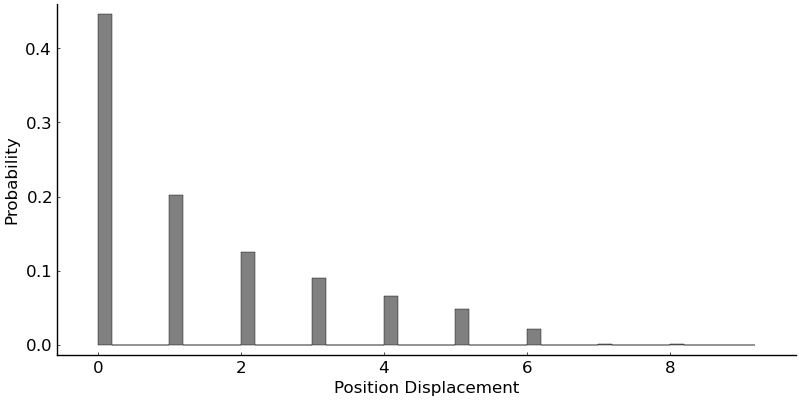

In [23]:
preds = posterior_predictive(x -> transpostions(parms, n_study, n_items; x...), chain, 1000)
preds = vcat(preds...)
p4 = histogram(preds, xlabel="Position Displacement", ylabel="Probability", xaxis=font(font_size),
    yaxis=font(font_size), grid=false, normalize = :probability, color=:grey, leg=false, size=(800,400),
    titlefont=font(font_size), linewidth=0.3)

#### Primacy Effect

The posterior predictive distribution for the primacy effect is plotted below. As you can see, there is a marked decrease in accuracy as a function of position. 

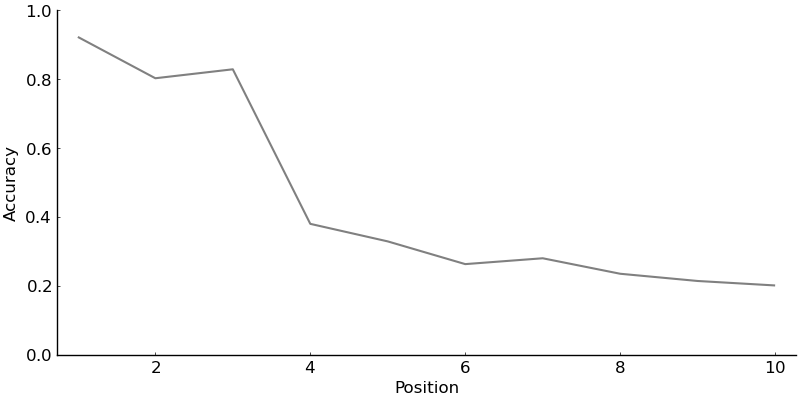

In [24]:
preds = posterior_predictive(x -> serial_position(parms, n_study, n_items; x...), chain, 1000)
preds = hcat(preds...)
sp_effect = mean(preds, dims=2)
p5 = plot(1:n_items, sp_effect, xlabel="Position", ylims = (0,1), ylabel="Accuracy", xaxis=font(font_size),
    yaxis=font(font_size), grid=false, color=:grey, leg=false, size=(800,400),
    titlefont=font(font_size), linewidth=1.5)